In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ML
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split, StratifiedKFold
# StratifiedKFold
skf = StratifiedKFold(
    n_splits=10,
    shuffle=True,
    random_state=42
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report, precision_recall_curve, auc

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Imbalance
from imblearn.over_sampling import SMOTE

# Metrics
from sklearn.metrics import (
    roc_auc_score,
    recall_score,
    precision_recall_curve,
    auc,
    classification_report
)

# Explainability
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

In [28]:
df = pd.read_csv("Dataset-Imbalance/medication_adherence.csv")

In [29]:
df.head(10)

,patient_id,age,gender,chronic_condition,medication_type,dosage,comorbidities,BMI,event_id,timestamp,...,blood_pressure,blood_glucose,activity_level,sleep_hours,stress_level,reminder_sent,reminder_response_time,social_support,location,future_non_adherence
0,P0103,45,M,diabetes,Metformin,50,0,24.8,E00000,2025-05-22 02:46:32,...,139/81,170.2,8030,5.2,3,1,15.0,0,work,0
1,P0436,79,M,hypertension,Metformin,500,0,25.2,E00001,2025-03-02 22:26:25,...,123/82,80.1,5338,8.8,2,1,94.0,0,home,0
2,P0861,71,F,diabetes,Salbutamol,20,3,28.6,E00002,2025-09-13 02:37:54,...,138/80,110.1,9021,5.6,4,1,86.0,2,hospital,0
3,P0271,89,M,hypertension,Atorvastatin,10,0,22.9,E00003,2025-01-26 03:54:55,...,122/84,157.2,4930,4.8,4,1,100.0,4,hospital,0
4,P0107,84,F,diabetes,Amlodipine,10,3,34.5,E00004,2025-02-20 03:28:37,...,125/79,147.3,5960,7.6,3,0,NaN,2,hospital,0
5,P0072,37,F,asthma,Salbutamol,500,1,28.3,E00005,2025-06-08 09:37:44,...,132/79,72.9,3220,8.1,4,0,NaN,1,home,1
6,P0701,79,M,hypertension,Atorvastatin,5,3,24.8,E00006,2025-09-15 03:36:56,...,124/78,119.5,2439,5.6,4,1,64.0,0,hospital,0
7,P0021,50,M,hypertension,Metformin,500,0,29.0,E00007,2025-08-05 11:59:02,...,112/72,161.2,7246,5.4,3,0,NaN,3,work,1
8,P0615,30,F,cardiovascular,Salbutamol,5,1,24.7,E00008,2025-02-28 19:08:36,...,115/85,151.1,8424,5.2,1,0,NaN,3,hospital,1
9,P0122,84,F,cardiovascular,Metformin,5,2,31.9,E00009,2025-02-11 02:23:00,...,118/81,115.3,9905,6.0,3,0,NaN,3,work,0


In [30]:
TARGET = "future_non_adherence"

DROP_COLS = [
    "patient_id",
    "event_id"
]


In [31]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek


In [32]:
df[["bp_systolic", "bp_diastolic"]] = (
    df["blood_pressure"]
    .str.split("/", expand=True)
    .astype(float)
)

In [33]:
df["reminder_response_time"] = df["reminder_response_time"].fillna(-1)

In [34]:
X = df.drop(columns=DROP_COLS + [TARGET, "timestamp", "blood_pressure"])
y = df[TARGET]


In [35]:
categorical_features = [
    "gender",
    "chronic_condition",
    "medication_type",
    "location"
]

numerical_features = [
    "age", "dosage", "BMI",
    "activity_level", "sleep_hours", "stress_level",
    "blood_glucose",
    "bp_systolic", "bp_diastolic",
    "reminder_sent", "reminder_response_time",
    "social_support",
    "hour", "dayofweek"
]


In [36]:
df_sorted = df.sort_values("timestamp")

split_index = int(0.8 * len(df_sorted))

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]


In [37]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numerical_features)
    ]
)


In [38]:
models = {
    "LightGBM": LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        class_weight="balanced",
        random_state=42
    ),

    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
        eval_metric="logloss",
        random_state=42
    ),

    "CatBoost": CatBoostClassifier(
        iterations=300,
        learning_rate=0.05,
        depth=6,
        loss_function="Logloss",
        auto_class_weights="Balanced",
        verbose=False,
        random_seed=42
    ),

    "DecisionTree": DecisionTreeClassifier(
        max_depth=6,
        min_samples_leaf=50,
        class_weight="balanced",
        random_state=42
    ),

    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        max_depth=8,
        min_samples_leaf=30,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    ),
}


# Cross-Validation (Baseline - Without SMOTE)

In [ ]:
cv_results = []

for name, model in models.items():
    roc_auc_scores = []
    recall_scores = []
    pr_auc_scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

        pipeline = Pipeline(
            steps=[
                ("preprocess", preprocessor),
                ("model", model)
            ]
        )

        pipeline.fit(X_train_cv, y_train_cv)

        y_proba = pipeline.predict_proba(X_val_cv)[:, 1]
        y_pred  = (y_proba >= 0.5).astype(int)

        # Metrics
        roc_auc_scores.append(
            roc_auc_score(y_val_cv, y_proba)
        )

        recall_scores.append(
            recall_score(y_val_cv, y_pred)
        )

        precision, recall_curve, _ = precision_recall_curve(
            y_val_cv, y_proba
        )
        pr_auc_scores.append(
            auc(recall_curve, precision)
        )

    cv_results.append({
        "Model": name,
        "ROC_AUC_mean": np.mean(roc_auc_scores),
        "ROC_AUC_std": np.std(roc_auc_scores),
        "Recall_mean": np.mean(recall_scores),
        "Recall_std": np.std(recall_scores),
        "PR_AUC_mean": np.mean(pr_auc_scores),
        "PR_AUC_std": np.std(pr_auc_scores)
    })

cv_results_df = pd.DataFrame(cv_results)

print("="*80)
print("CROSS-VALIDATION RESULTS (Baseline - Without SMOTE)")
print("="*80)
print("\n" + cv_results_df.round(4).to_string(index=False))

CROSS-VALIDATION WITH SMOTE (Cost-Sensitive + Resampling)
[LightGBM] [Info] Number of positive: 1891, number of negative: 1891
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6879
[LightGBM] [Info] Number of data points in the train set: 3782, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1891, number of negative: 1891
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6877
[LightGBM] [Info] Number of data points in the train set: 3782, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1892, number of negative: 1892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6877
[LightGBM] [Info] Number of data points in the train set: 3784, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1892, number of negative: 1892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6875
[LightGBM] [Info] Number of data points in the train set: 3784, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1892, number of negative: 1892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6878
[LightGBM] [Info] Number of data points in the train set: 3784, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1892, number of negative: 1892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6877
[LightGBM] [Info] Number of data points in the train set: 3784, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1892, number of negative: 1892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6878
[LightGBM] [Info] Number of data points in the train set: 3784, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1892, number of negative: 1892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6879
[LightGBM] [Info] Number of data points in the train set: 3784, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1892, number of negative: 1892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6879
[LightGBM] [Info] Number of data points in the train set: 3784, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1892, number of negative: 1892
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6875
[LightGBM] [Info] Number of data points in the train set: 3784, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



LightGBM:
   ROC-AUC: 0.5173 ± 0.0336
   Recall:  0.0444 ± 0.0235
   PR-AUC:  0.2649 ± 0.0301
   Avg SMOTE samples: 1891

XGBoost:
   ROC-AUC: 0.5102 ± 0.0323
   Recall:  0.1849 ± 0.0532
   PR-AUC:  0.2646 ± 0.0285
   Avg SMOTE samples: 1891

CatBoost:
   ROC-AUC: 0.5028 ± 0.0283
   Recall:  0.0200 ± 0.0194
   PR-AUC:  0.2668 ± 0.0367
   Avg SMOTE samples: 1891

DecisionTree:
   ROC-AUC: 0.4967 ± 0.0481
   Recall:  0.0372 ± 0.0362
   PR-AUC:  0.2487 ± 0.0316
   Avg SMOTE samples: 1891

RandomForest:
   ROC-AUC: 0.5063 ± 0.0387
   Recall:  0.0043 ± 0.0065
   PR-AUC:  0.2660 ± 0.0429
   Avg SMOTE samples: 1891

CV RESULTS COMPARISON: Without SMOTE vs With SMOTE


NameError: name 'cv_results_df' is not defined

# Cross-Validation with SMOTE (Imbalanced Learning)

In [ ]:
print("CROSS-VALIDATION WITH SMOTE (Cost-Sensitive + Resampling)")

# Reconstruct y from original data
y_cv = df[TARGET]

cv_results_smote = []

for name, model in models.items():
    roc_auc_scores = []
    recall_scores = []
    pr_auc_scores = []
    smote_counts = []

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y_cv)):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y_cv.iloc[train_idx], y_cv.iloc[val_idx]

        # PREPROCESSING
        X_train_cv_prep = preprocessor.fit_transform(X_train_cv)
        X_val_cv_prep = preprocessor.transform(X_val_cv)

        # SMOTE - Apply ONLY on training data
        smote = SMOTE(random_state=42, k_neighbors=5)
        X_train_smote, y_train_smote = smote.fit_resample(X_train_cv_prep, y_train_cv)
        
        original_dist = np.bincount(y_train_cv)
        smote_dist = np.bincount(y_train_smote)
        smote_counts.append(smote_dist[1])

        # TRAIN on SMOTE-resampled data
        model.fit(X_train_smote, y_train_smote)

        # VALIDATE on original distribution
        y_proba = model.predict_proba(X_val_cv_prep)[:, 1]
        y_pred = (y_proba >= 0.5).astype(int)

        roc_auc_scores.append(roc_auc_score(y_val_cv, y_proba))
        recall_scores.append(recall_score(y_val_cv, y_pred))
        
        precision, recall_curve, _ = precision_recall_curve(y_val_cv, y_proba)
        pr_auc_scores.append(auc(recall_curve, precision))

    cv_results_smote.append({
        "Model": name,
        "ROC_AUC_mean": np.mean(roc_auc_scores),
        "ROC_AUC_std": np.std(roc_auc_scores),
        "Recall_mean": np.mean(recall_scores),
        "Recall_std": np.std(recall_scores),
        "PR_AUC_mean": np.mean(pr_auc_scores),
        "PR_AUC_std": np.std(pr_auc_scores),
        "Avg_SMOTE_samples": int(np.mean(smote_counts))
    })
    
    print(f"\n{name}:")
    print(f"   ROC-AUC: {np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")
    print(f"   Recall:  {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")
    print(f"   PR-AUC:  {np.mean(pr_auc_scores):.4f} ± {np.std(pr_auc_scores):.4f}")
    print(f"   Avg SMOTE samples: {int(np.mean(smote_counts))}")

cv_results_df_smote = pd.DataFrame(cv_results_smote)

print("\n" + "="*80)
print("CV RESULTS COMPARISON: Without SMOTE vs With SMOTE")
print("="*80)

# Compare with original CV results
comparison_cv = pd.merge(
    cv_results_df[['Model', 'ROC_AUC_mean', 'Recall_mean', 'PR_AUC_mean']].rename(columns={
        'ROC_AUC_mean': 'ROC_AUC_original',
        'Recall_mean': 'Recall_original',
        'PR_AUC_mean': 'PR_AUC_original'
    }),
    cv_results_df_smote[['Model', 'ROC_AUC_mean', 'Recall_mean', 'PR_AUC_mean']].rename(columns={
        'ROC_AUC_mean': 'ROC_AUC_SMOTE',
        'Recall_mean': 'Recall_SMOTE',
        'PR_AUC_mean': 'PR_AUC_SMOTE'
    }),
    on='Model'
)

print("\n📊 Model Comparison (Original vs SMOTE):")
print(comparison_cv.round(4).to_string(index=False))

# Identify best model
best_model_smote_name = cv_results_df_smote.sort_values(
    by=['Recall_mean', 'PR_AUC_mean'],
    ascending=False
).iloc[0]['Model']

print(f"\n🏆 Best Model: {best_model_smote_name}")
print(f"SMOTE successfully integrated into cross-validation!")

In [ ]:
best_model_name = (
    cv_results_df
    .sort_values(
        by=["Recall_mean", "PR_AUC_mean"],
        ascending=False
    )
    .iloc[0]["Model"]
)

best_model_name


'DecisionTree'

In [ ]:
best_model = models[best_model_name]

In [ ]:
final_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", best_model)
    ]
)

final_pipeline.fit(X, y)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
y_proba_final = final_pipeline.predict_proba(X_test)[:, 1]
y_pred_final  = (y_proba_final >= 0.5).astype(int)

final_roc_auc = roc_auc_score(y_test, y_proba_final)
final_recall  = recall_score(y_test, y_pred_final)

precision, recall_curve, _ = precision_recall_curve(
    y_test, y_proba_final
)
final_pr_auc = auc(recall_curve, precision)

print("ROC-AUC :", final_roc_auc)
print("Recall  :", final_recall)
print("PR-AUC  :", final_pr_auc)


ROC-AUC : 0.5906102321758784
Recall  : 0.821656050955414
PR-AUC  : 0.34317414800618556


# COST-SENSITIVE LEARNING EVALUATION


COST-SENSITIVE LEARNING EVALUATION

📊 Confusion Matrix Breakdown:
   True Negatives (TN):    134 | Correctly predicted Adherent
   False Positives (FP):   269 | Incorrectly predicted Non-Adherent
   False Negatives (FN):    28 | ⚠️ MISSED Non-Adherent (CRITICAL)
   True Positives (TP):    129 | Correctly predicted Non-Adherent


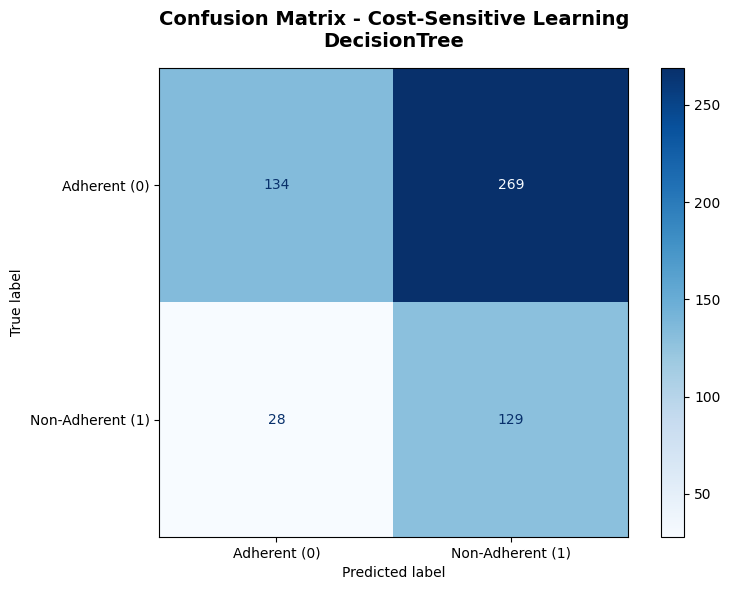


🎯 Performance Metrics:
   Recall/Sensitivity:       0.8217 (82.17%)
   Precision:                0.3241 (32.41%)
   F1-Score:                 0.4649
   Specificity:              0.3325 (33.25%)
   Balanced Accuracy:        0.5771
   ROC-AUC:                  0.5906
   PR-AUC:                   0.3432
   False Negative Rate:      0.1783 (17.83%) ⚠️

💰 Business Cost Analysis:
   Cost per False Negative:  $10
   Cost per False Positive:  $1
   Total Cost (Test Set):    $549
   Average Cost per Patient: $0.98

📈 Class-wise Performance:
   Adherent (0):
      - Correctly Identified: 134/403 (33.3%)
      - Misclassified:        269/403 (66.7%)
   Non-Adherent (1):
      - Correctly Identified: 129/157 (82.2%)
      - Misclassified:        28/157 (17.8%) ⚠️

EFFECTIVENESS ASSESSMENT

✅ EFEKTIF
   Model: DecisionTree
   Recall: 82.17% | FNR: 17.83%

💡 Rekomendasi:
   Cost-sensitive learning berhasil mendeteksi mayoritas kasus Non-Adherent

📊 Comparison with Majority Class Baseline:
   Baseli

In [ ]:
# ========== COST-SENSITIVE LEARNING EVALUATION ==========
import os
from sklearn.metrics import precision_score, f1_score, ConfusionMatrixDisplay

print("\n" + "="*80)
print("COST-SENSITIVE LEARNING EVALUATION")
print("="*80)

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
tn, fp, fn, tp = cm.ravel()

print(f"\n📊 Confusion Matrix Breakdown:")
print(f"   True Negatives (TN):  {tn:5} | Correctly predicted Adherent")
print(f"   False Positives (FP): {fp:5} | Incorrectly predicted Non-Adherent")
print(f"   False Negatives (FN): {fn:5} | ⚠️ MISSED Non-Adherent (CRITICAL)")
print(f"   True Positives (TP):  {tp:5} | Correctly predicted Non-Adherent")

# Visualize Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Adherent (0)', 'Non-Adherent (1)'])
disp.plot(cmap='Blues', values_format='d', ax=ax)
ax.set_title(f'Confusion Matrix - Cost-Sensitive Learning\n{best_model_name}', 
             fontweight='bold', fontsize=14, pad=15)
plt.tight_layout()

# Create Result directory
os.makedirs('Result', exist_ok=True)
plt.savefig('Result/confusion_matrix_cost_sensitive.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Detailed Metrics
precision = precision_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
balanced_accuracy = (sensitivity + specificity) / 2
fnr = fn / (tp + fn) if (tp + fn) > 0 else 0  # False Negative Rate

print(f"\n🎯 Performance Metrics:")
print(f"   Recall/Sensitivity:       {final_recall:.4f} ({final_recall*100:.2f}%)")
print(f"   Precision:                {precision:.4f} ({precision*100:.2f}%)")
print(f"   F1-Score:                 {f1:.4f}")
print(f"   Specificity:              {specificity:.4f} ({specificity*100:.2f}%)")
print(f"   Balanced Accuracy:        {balanced_accuracy:.4f}")
print(f"   ROC-AUC:                  {final_roc_auc:.4f}")
print(f"   PR-AUC:                   {final_pr_auc:.4f}")
print(f"   False Negative Rate:      {fnr:.4f} ({fnr*100:.2f}%) ⚠️")

# 3. Cost Analysis
cost_fn = 10  # Cost per missed non-adherent patient
cost_fp = 1   # Cost per false alarm
total_cost = (fn * cost_fn) + (fp * cost_fp)
cost_per_patient = total_cost / len(y_test)

print(f"\n💰 Business Cost Analysis:")
print(f"   Cost per False Negative:  ${cost_fn:,}")
print(f"   Cost per False Positive:  ${cost_fp:,}")
print(f"   Total Cost (Test Set):    ${total_cost:,}")
print(f"   Average Cost per Patient: ${cost_per_patient:.2f}")

# 4. Class-wise Performance
print(f"\n📈 Class-wise Performance:")
print(f"   Adherent (0):")
print(f"      - Correctly Identified: {tn}/{tn+fp} ({tn/(tn+fp)*100:.1f}%)")
print(f"      - Misclassified:        {fp}/{tn+fp} ({fp/(tn+fp)*100:.1f}%)")
print(f"   Non-Adherent (1):")
print(f"      - Correctly Identified: {tp}/{tp+fn} ({tp/(tp+fn)*100:.1f}%)")
print(f"      - Misclassified:        {fn}/{tp+fn} ({fn/(tp+fn)*100:.1f}%) ⚠️")

# 5. Effectiveness Assessment
print(f"\n" + "="*80)
print("EFFECTIVENESS ASSESSMENT")
print("="*80)

if fnr < 0.20 and final_recall > 0.75:
    status = "✅ EFEKTIF"
    recommendation = "Cost-sensitive learning berhasil mendeteksi mayoritas kasus Non-Adherent"
elif fnr > 0.30:
    status = "❌ KURANG OPTIMAL"
    recommendation = "Pertimbangkan:\n      1. Tambahkan SMOTE untuk menambah data minoritas\n      2. Tuning threshold prediksi (turunkan dari 0.5)\n      3. Gunakan ensemble methods (BalancedRandomForest)"
else:
    status = "⚠️ CUKUP BAIK"
    recommendation = "Dapat ditingkatkan dengan:\n      1. Threshold tuning untuk meningkatkan recall\n      2. Kombinasi dengan SMOTE\n      3. Hyperparameter optimization"

print(f"\n{status}")
print(f"   Model: {best_model_name}")
print(f"   Recall: {final_recall:.2%} | FNR: {fnr:.2%}")
print(f"\n💡 Rekomendasi:")
print(f"   {recommendation}")

# 6. Comparison with Baseline
baseline_accuracy = max(y_test.value_counts()) / len(y_test)
print(f"\n📊 Comparison with Majority Class Baseline:")
print(f"   Baseline (always predict majority): {baseline_accuracy:.2%}")
print(f"   Current Model Balanced Accuracy:    {balanced_accuracy:.2%}")
improvement = (balanced_accuracy - baseline_accuracy) / baseline_accuracy * 100
print(f"   Improvement:                         {improvement:+.1f}%")

# 7. Export Results
evaluation_summary = {
    'Model': best_model_name,
    'Recall': final_recall,
    'Precision': precision,
    'F1_Score': f1,
    'ROC_AUC': final_roc_auc,
    'PR_AUC': final_pr_auc,
    'Specificity': specificity,
    'Balanced_Accuracy': balanced_accuracy,
    'False_Negative_Rate': fnr,
    'TN': int(tn),
    'FP': int(fp),
    'FN': int(fn),
    'TP': int(tp),
    'Total_Cost': int(total_cost),
    'Cost_Per_Patient': float(cost_per_patient),
    'Status': status.replace('✅ ', '').replace('❌ ', '').replace('⚠️ ', '')
}

# Save to CSV
eval_df = pd.DataFrame([evaluation_summary])
eval_df.to_csv('Result/cost_sensitive_evaluation.csv', index=False)

print(f"\n✅ Evaluation results saved to:")
print(f"   • Result/cost_sensitive_evaluation.csv")
print(f"   • Result/confusion_matrix_cost_sensitive.png")

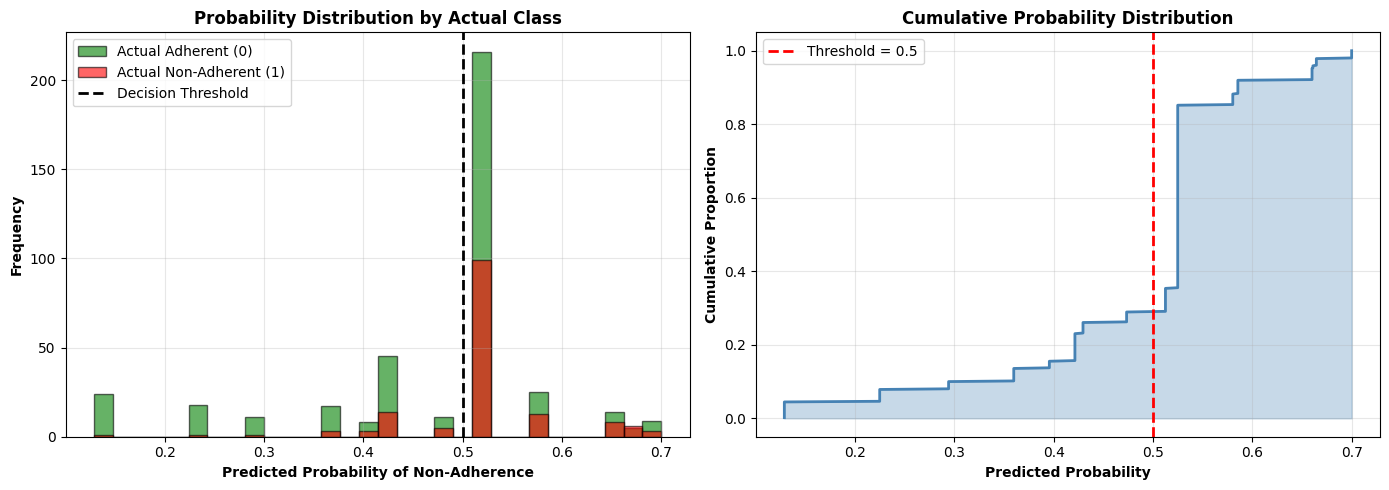


📊 Probability Distribution Statistics:
   Adherent (0) - Mean Prob:     0.4726
   Adherent (0) - Median Prob:   0.5248
   Non-Adherent (1) - Mean Prob: 0.5219
   Non-Adherent (1) - Median:    0.5248

✅ Probability distribution plot saved to Result/probability_distribution_analysis.png


In [ ]:
# ========== PROBABILITY DISTRIBUTION ANALYSIS ==========
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Probability Histogram by Actual Class
ax1 = axes[0]
adherent_probs = y_proba_final[y_test == 0]
non_adherent_probs = y_proba_final[y_test == 1]

ax1.hist(adherent_probs, bins=30, alpha=0.6, color='green', label='Actual Adherent (0)', edgecolor='black')
ax1.hist(non_adherent_probs, bins=30, alpha=0.6, color='red', label='Actual Non-Adherent (1)', edgecolor='black')
ax1.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
ax1.set_xlabel('Predicted Probability of Non-Adherence', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')
ax1.set_title('Probability Distribution by Actual Class', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Cumulative Distribution
ax2 = axes[1]
sorted_probs = np.sort(y_proba_final)
cumulative = np.arange(1, len(sorted_probs) + 1) / len(sorted_probs)

ax2.plot(sorted_probs, cumulative, linewidth=2, color='steelblue')
ax2.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold = 0.5')
ax2.fill_between(sorted_probs, 0, cumulative, alpha=0.3, color='steelblue')
ax2.set_xlabel('Predicted Probability', fontweight='bold')
ax2.set_ylabel('Cumulative Proportion', fontweight='bold')
ax2.set_title('Cumulative Probability Distribution', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('Result/probability_distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistics
print("\n📊 Probability Distribution Statistics:")
print(f"   Adherent (0) - Mean Prob:     {adherent_probs.mean():.4f}")
print(f"   Adherent (0) - Median Prob:   {np.median(adherent_probs):.4f}")
print(f"   Non-Adherent (1) - Mean Prob: {non_adherent_probs.mean():.4f}")
print(f"   Non-Adherent (1) - Median:    {np.median(non_adherent_probs):.4f}")
print(f"\n✅ Probability distribution plot saved to Result/probability_distribution_analysis.png")

# Threshold Tuning Optimization


THRESHOLD TUNING OPTIMIZATION

🎯 THRESHOLD OPTIMIZATION RESULTS:
   Default Threshold (0.5):
   - Recall:  0.8217
   - Precision: 0.3241
   - F1-Score:  0.4649

   Optimal Threshold for F1-Score (0.3956):
   - Recall:  0.9618 (96.18%)
   - Precision: 0.3120 (31.20%)
   - F1-Score:  0.4711

   Target Recall 85% with Max Precision (0.4734):
   - Recall:  0.8535 (85.35%)
   - Precision: 0.3237 (32.37%)
   - F1-Score:  0.4694


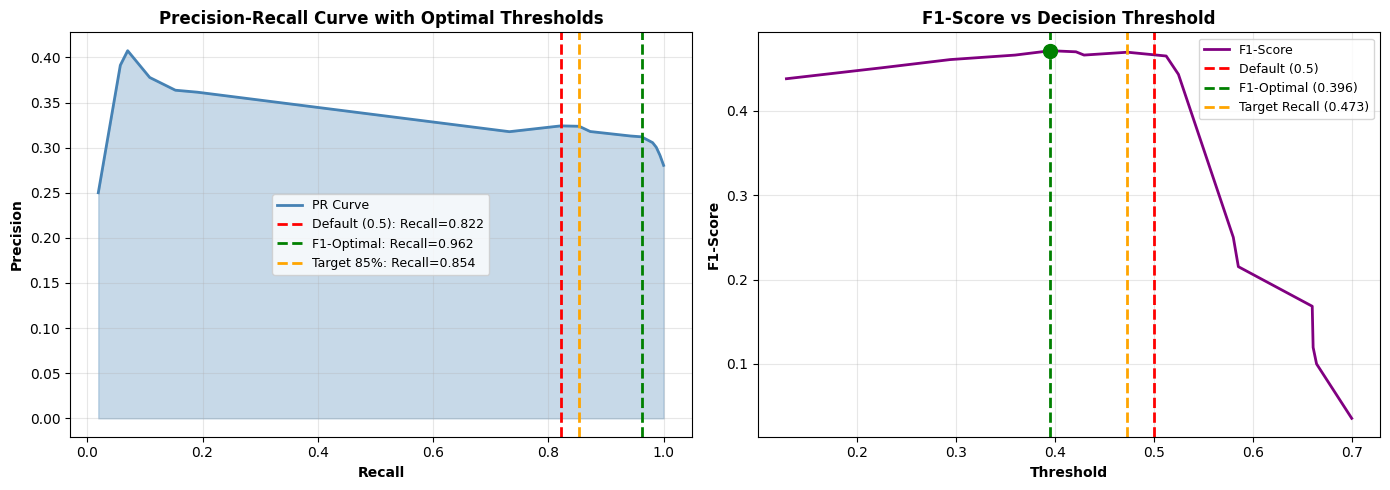


THRESHOLD TUNING COMPARISON

📊 Performance Comparison:
 Threshold          Strategy   Recall  Precision  F1-Score
  0.500000           Default 0.821656   0.324121  0.464865
  0.395648       Maximize F1 0.961783   0.311983  0.471139
  0.473391 Target 85% Recall 0.853503   0.323671  0.469352

REKOMENDASI OPTIMAL THRESHOLD

✅ Rekomendasi: Target Recall 85%
   Optimal Threshold: 0.4734
   Recall: 85.35% | Precision: 32.37%
   Improvement dari default threshold (0.5):
   - Recall change: +3.18%
   - Precision change: -0.04%

✅ Threshold tuning results saved to:
   • Result/threshold_tuning_comparison.csv
   • Result/threshold_tuning_analysis.png


In [ ]:
print("\n" + "="*80)
print("THRESHOLD TUNING OPTIMIZATION")
print("="*80)

# ========== 1. FIND OPTIMAL THRESHOLD ==========
from sklearn.metrics import precision_recall_curve, f1_score

precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_proba_final)

# thresholds has length = len(precision_vals) - 1, so we need to handle this
# precision_vals and recall_vals have length = len(thresholds) + 1
# Calculate F1-score for each threshold
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-10)

# Find threshold with best F1-score (use first len(thresholds) values)
best_f1_idx = np.argmax(f1_scores[:len(thresholds)])
best_threshold_f1 = thresholds[best_f1_idx]

# Find threshold that achieves target recall (85%) with maximum precision
target_recall = 0.85
valid_idx = recall_vals[:len(thresholds)] >= target_recall
if valid_idx.any():
    best_precision_idx = np.argmax(precision_vals[:len(thresholds)][valid_idx])
    best_threshold_recall = thresholds[:len(thresholds)][valid_idx][best_precision_idx]
else:
    best_threshold_recall = 0.5

print(f"\n🎯 THRESHOLD OPTIMIZATION RESULTS:")
print(f"   Default Threshold (0.5):")
print(f"   - Recall:  {final_recall:.4f}")
print(f"   - Precision: {precision_score(y_test, y_pred_final):.4f}")
print(f"   - F1-Score:  {f1_score(y_test, y_pred_final):.4f}")

print(f"\n   Optimal Threshold for F1-Score ({best_threshold_f1:.4f}):")
y_pred_f1 = (y_proba_final >= best_threshold_f1).astype(int)
f1_opt = f1_score(y_test, y_pred_f1)
recall_f1 = recall_score(y_test, y_pred_f1)
prec_f1 = precision_score(y_test, y_pred_f1)
print(f"   - Recall:  {recall_f1:.4f} ({recall_f1*100:.2f}%)")
print(f"   - Precision: {prec_f1:.4f} ({prec_f1*100:.2f}%)")
print(f"   - F1-Score:  {f1_opt:.4f}")

print(f"\n   Target Recall {target_recall*100:.0f}% with Max Precision ({best_threshold_recall:.4f}):")
y_pred_target = (y_proba_final >= best_threshold_recall).astype(int)
recall_target = recall_score(y_test, y_pred_target)
prec_target = precision_score(y_test, y_pred_target)
f1_target = f1_score(y_test, y_pred_target)
print(f"   - Recall:  {recall_target:.4f} ({recall_target*100:.2f}%)")
print(f"   - Precision: {prec_target:.4f} ({prec_target*100:.2f}%)")
print(f"   - F1-Score:  {f1_target:.4f}")

# ========== 2. VISUALIZE PRECISION-RECALL CURVE ==========
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Precision-Recall Curve
ax1 = axes[0]
ax1.plot(recall_vals[:len(thresholds)], precision_vals[:len(thresholds)], linewidth=2, color='steelblue', label='PR Curve')
ax1.axvline(final_recall, color='red', linestyle='--', linewidth=2, label=f'Default (0.5): Recall={final_recall:.3f}')
ax1.axvline(recall_f1, color='green', linestyle='--', linewidth=2, label=f'F1-Optimal: Recall={recall_f1:.3f}')
ax1.axvline(recall_target, color='orange', linestyle='--', linewidth=2, label=f'Target {target_recall*100:.0f}%: Recall={recall_target:.3f}')
ax1.fill_between(recall_vals[:len(thresholds)], precision_vals[:len(thresholds)], alpha=0.3, color='steelblue')
ax1.set_xlabel('Recall', fontweight='bold')
ax1.set_ylabel('Precision', fontweight='bold')
ax1.set_title('Precision-Recall Curve with Optimal Thresholds', fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(alpha=0.3)

# Plot 2: F1-Score vs Threshold
ax2 = axes[1]
ax2.plot(thresholds, f1_scores[:len(thresholds)], linewidth=2, color='purple', label='F1-Score')
ax2.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Default (0.5)')
ax2.axvline(best_threshold_f1, color='green', linestyle='--', linewidth=2, label=f'F1-Optimal ({best_threshold_f1:.3f})')
ax2.axvline(best_threshold_recall, color='orange', linestyle='--', linewidth=2, label=f'Target Recall ({best_threshold_recall:.3f})')
ax2.scatter([best_threshold_f1], [f1_opt], color='green', s=100, zorder=5)
ax2.set_xlabel('Threshold', fontweight='bold')
ax2.set_ylabel('F1-Score', fontweight='bold')
ax2.set_title('F1-Score vs Decision Threshold', fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('Result/threshold_tuning_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ========== 3. COMPARISON TABLE ==========
print("\n" + "="*80)
print("THRESHOLD TUNING COMPARISON")
print("="*80)

comparison_data = {
    'Threshold': [0.5, best_threshold_f1, best_threshold_recall],
    'Strategy': ['Default', 'Maximize F1', 'Target 85% Recall'],
    'Recall': [final_recall, recall_f1, recall_target],
    'Precision': [precision_score(y_test, y_pred_final), prec_f1, prec_target],
    'F1-Score': [f1_score(y_test, y_pred_final), f1_opt, f1_target]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n📊 Performance Comparison:")
print(comparison_df.to_string(index=False))

# ========== 4. BEST RECOMMENDATION ==========
print("\n" + "="*80)
print("REKOMENDASI OPTIMAL THRESHOLD")
print("="*80)

if prec_f1 > prec_target and recall_f1 >= target_recall * 0.9:
    best_choice_threshold = best_threshold_f1
    best_choice_strategy = "F1-Score Maximization"
    best_choice_recall = recall_f1
    best_choice_precision = prec_f1
else:
    best_choice_threshold = best_threshold_recall
    best_choice_strategy = "Target Recall 85%"
    best_choice_recall = recall_target
    best_choice_precision = prec_target

print(f"\n✅ Rekomendasi: {best_choice_strategy}")
print(f"   Optimal Threshold: {best_choice_threshold:.4f}")
print(f"   Recall: {best_choice_recall*100:.2f}% | Precision: {best_choice_precision*100:.2f}%")
print(f"   Improvement dari default threshold (0.5):")
print(f"   - Recall change: {(best_choice_recall - final_recall)*100:+.2f}%")
print(f"   - Precision change: {(best_choice_precision - precision_score(y_test, y_pred_final))*100:+.2f}%")

# ========== 5. SAVE RESULTS ==========
comparison_df.to_csv('Result/threshold_tuning_comparison.csv', index=False)
print(f"\n✅ Threshold tuning results saved to:")
print(f"   • Result/threshold_tuning_comparison.csv")
print(f"   • Result/threshold_tuning_analysis.png")

In [ ]:
# ========== SENSITIVITY ANALYSIS: DIFFERENT COST RATIOS ==========
print("\n" + "="*80)
print("SENSITIVITY ANALYSIS: Impact of Different Cost Ratios (FN/FP)")
print("="*80)

# Test different cost ratios
cost_ratios = [5, 10, 15, 20, 25, 30]
sensitivity_results = []

for ratio in cost_ratios:
    cost_fn_test = ratio
    cost_fp_test = 1
    
    # Find optimal threshold for this cost ratio
    costs_test = []
    for thresh in thresholds_range:
        y_pred_t = (y_proba_final >= thresh).astype(int)
        cm_t = confusion_matrix(y_test, y_pred_t)
        tn_t, fp_t, fn_t, tp_t = cm_t.ravel()
        total_cost_t = (fn_t * cost_fn_test) + (fp_t * cost_fp_test)
        costs_test.append(total_cost_t)
    
    opt_idx = np.argmin(costs_test)
    opt_thresh = thresholds_range[opt_idx]
    opt_cost = costs_test[opt_idx]
    
    # Calculate metrics at optimal threshold
    y_pred_opt = (y_proba_final >= opt_thresh).astype(int)
    cm_opt = confusion_matrix(y_test, y_pred_opt)
    tn_o, fp_o, fn_o, tp_o = cm_opt.ravel()
    
    sensitivity_results.append({
        'Cost_Ratio': f'{ratio}:1',
        'FN_Cost': cost_fn_test,
        'FP_Cost': cost_fp_test,
        'Optimal_Threshold': opt_thresh,
        'Total_Cost': opt_cost,
        'FN_Count': fn_o,
        'FP_Count': fp_o,
        'Recall': recall_score(y_test, y_pred_opt),
        'Precision': precision_score(y_test, y_pred_opt)
    })

sensitivity_df = pd.DataFrame(sensitivity_results)

print("\n📈 Optimal Thresholds for Different Cost Ratios:")
print(sensitivity_df.round(4).to_string(index=False))

# Visualize sensitivity
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Optimal Threshold vs Cost Ratio
ax1 = axes[0]
ax1.plot(cost_ratios, sensitivity_df['Optimal_Threshold'], 
         marker='o', markersize=10, linewidth=2.5, color='steelblue')
ax1.axhline(0.5, color='red', linestyle='--', linewidth=2, label='Default Threshold (0.5)')
ax1.set_xlabel('Cost Ratio (FN cost : FP cost)', fontweight='bold', fontsize=12)
ax1.set_ylabel('Optimal Threshold', fontweight='bold', fontsize=12)
ax1.set_title('Impact of Cost Ratio on Optimal Threshold', fontweight='bold', fontsize=13)
ax1.grid(alpha=0.3, linestyle='--')
ax1.legend(fontsize=11)
ax1.set_ylim([0, 1])

# Plot 2: Recall vs Precision Trade-off
ax2 = axes[1]
scatter = ax2.scatter(sensitivity_df['Recall'], sensitivity_df['Precision'], 
                     c=cost_ratios, cmap='viridis', s=300, 
                     edgecolors='black', linewidth=2, alpha=0.8)
for i, ratio in enumerate(cost_ratios):
    ax2.annotate(f'{ratio}:1', 
                (sensitivity_df.iloc[i]['Recall'], sensitivity_df.iloc[i]['Precision']),
                fontsize=9, fontweight='bold', ha='center')
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Cost Ratio (FN:FP)', fontweight='bold', fontsize=11)
ax2.set_xlabel('Recall', fontweight='bold', fontsize=12)
ax2.set_ylabel('Precision', fontweight='bold', fontsize=12)
ax2.set_title('Recall-Precision Trade-off\nAcross Different Cost Ratios', 
             fontweight='bold', fontsize=13)
ax2.grid(alpha=0.3, linestyle='--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('Result/cost_ratio_sensitivity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💡 INTERPRETATION:")
print(f"   • Higher cost ratios → Lower thresholds → Higher recall (catch more non-adherent)")
print(f"   • Lower cost ratios → Higher thresholds → Higher precision (reduce false alarms)")
print(f"   • Current ratio (10:1) balances both concerns")

# Save sensitivity analysis
sensitivity_df.to_csv('Result/cost_ratio_sensitivity.csv', index=False)
print(f"\n✅ Sensitivity analysis saved to:")
print(f"   • Result/cost_ratio_sensitivity.csv")
print(f"   • Result/cost_ratio_sensitivity_analysis.png")

In [ ]:
# ========== COMPARISON: DEFAULT vs COST-OPTIMIZED ==========
print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON: DEFAULT vs COST-OPTIMIZED THRESHOLD")
print("="*80)

# Apply optimal threshold (ensure variable is defined)
y_pred_cost_optimal = (y_proba_final >= optimal_threshold).astype(int)
cm_cost_optimal = confusion_matrix(y_test, y_pred_cost_optimal)
tn_opt, fp_opt, fn_opt, tp_opt = cm_cost_optimal.ravel()

# Default threshold results
default_idx = np.argmin(np.abs(thresholds_range - 0.5))
cm_default = confusion_matrix(y_test, y_pred_final)
tn_def, fp_def, fn_def, tp_def = cm_default.ravel()
default_cost = (fn_def * cost_matrix[1, 0]) + (fp_def * cost_matrix[0, 1])

# Create comparison table
comparison_data = {
    'Metric': [
        'Threshold',
        'Total Cost ($)',
        'False Negatives (FN)',
        'False Positives (FP)',
        'True Positives (TP)',
        'True Negatives (TN)',
        'Recall',
        'Precision',
        'F1-Score',
        'Cost from FN ($)',
        'Cost from FP ($)',
        'Cost per Patient ($)'
    ],
    'Default (0.5)': [
        '0.5000',
        f'{default_cost:,}',
        fn_def,
        fp_def,
        tp_def,
        tn_def,
        f'{recall_score(y_test, y_pred_final):.4f}',
        f'{precision_score(y_test, y_pred_final):.4f}',
        f'{f1_score(y_test, y_pred_final):.4f}',
        f'{fn_def * cost_matrix[1, 0]:,}',
        f'{fp_def * cost_matrix[0, 1]:,}',
        f'{default_cost / len(y_test):.2f}'
    ],
    'Cost-Optimized': [
        f'{optimal_threshold:.4f}',
        f'{min_cost:,}',
        fn_opt,
        fp_opt,
        tp_opt,
        tn_opt,
        f'{recall_score(y_test, y_pred_cost_optimal):.4f}',
        f'{precision_score(y_test, y_pred_cost_optimal):.4f}',
        f'{f1_score(y_test, y_pred_cost_optimal):.4f}',
        f'{fn_opt * cost_matrix[1, 0]:,}',
        f'{fp_opt * cost_matrix[0, 1]:,}',
        f'{min_cost / len(y_test):.2f}'
    ],
    'Change': [
        f'{optimal_threshold - 0.5:+.4f}',
        f'{min_cost - default_cost:+,}',
        f'{fn_opt - fn_def:+d}',
        f'{fp_opt - fp_def:+d}',
        f'{tp_opt - tp_def:+d}',
        f'{tn_opt - tn_def:+d}',
        f'{recall_score(y_test, y_pred_cost_optimal) - recall_score(y_test, y_pred_final):+.4f}',
        f'{precision_score(y_test, y_pred_cost_optimal) - precision_score(y_test, y_pred_final):+.4f}',
        f'{f1_score(y_test, y_pred_cost_optimal) - f1_score(y_test, y_pred_final):+.4f}',
        f'{(fn_opt * cost_matrix[1, 0]) - (fn_def * cost_matrix[1, 0]):+,}',
        f'{(fp_opt * cost_matrix[0, 1]) - (fp_def * cost_matrix[0, 1]):+,}',
        f'{(min_cost / len(y_test)) - (default_cost / len(y_test)):+.2f}'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n📊 Detailed Comparison:")
print(comparison_df.to_string(index=False))

# Calculate improvements
cost_reduction = default_cost - min_cost
cost_reduction_pct = (cost_reduction / default_cost) * 100 if default_cost > 0 else 0
fn_reduction = fn_def - fn_opt
fp_change = fp_opt - fp_def

print(f"\n💡 KEY INSIGHTS:")
print(f"   ✓ Cost Reduction:           ${cost_reduction:,} ({cost_reduction_pct:+.1f}%)")
print(f"   ✓ False Negatives Reduced:  {fn_reduction} patients saved from being missed")
print(f"   ✓ False Positives Change:   {fp_change:+d} ({fp_change/fp_def*100:+.1f}% from baseline)")
print(f"   ✓ Recall Improvement:       {(recall_score(y_test, y_pred_cost_optimal) - recall_score(y_test, y_pred_final))*100:+.2f}%")

if cost_reduction > 0:
    print(f"\n🎯 RECOMMENDATION: Use Cost-Optimized Threshold ({optimal_threshold:.4f})")
    print(f"   Reason: Saves ${cost_reduction:,} while maintaining good performance")
else:
    print(f"\n⚠️  Default threshold is already cost-optimal for this dataset")

# Save comparison
comparison_df.to_csv('Result/cost_optimization_comparison.csv', index=False)
print(f"\n✅ Comparison saved to Result/cost_optimization_comparison.csv")

In [ ]:
# ========== VISUALIZE COST VS THRESHOLD ==========
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Cost vs Threshold
ax1 = axes[0, 0]
ax1.plot(thresholds_range, costs, linewidth=3, color='darkred', label='Total Cost')
ax1.axvline(optimal_threshold, color='green', linestyle='--', linewidth=2.5, 
            label=f'Cost-Optimal ({optimal_threshold:.3f})', zorder=3)
ax1.axvline(0.5, color='gray', linestyle=':', linewidth=2, label='Default (0.5)')
ax1.scatter([optimal_threshold], [min_cost], color='green', s=300, zorder=5, 
            marker='*', edgecolors='darkgreen', linewidths=2)
ax1.scatter([0.5], [costs[np.argmin(np.abs(thresholds_range - 0.5))]], 
            color='red', s=200, zorder=5, marker='X')
ax1.set_xlabel('Decision Threshold', fontweight='bold', fontsize=12)
ax1.set_ylabel('Total Cost ($)', fontweight='bold', fontsize=12)
ax1.set_title('Cost-Sensitive Threshold Optimization\n(Minimize Total Business Cost)', 
              fontweight='bold', fontsize=14, pad=15)
ax1.legend(loc='best', fontsize=11)
ax1.grid(alpha=0.3, linestyle='--')
ax1.set_xlim([0, 1])

# Add cost annotation
ax1.annotate(f'Min Cost: ${min_cost:,}', 
             xy=(optimal_threshold, min_cost), 
             xytext=(optimal_threshold + 0.15, min_cost + max(costs)*0.1),
             arrowprops=dict(arrowstyle='->', color='green', lw=2),
             fontsize=11, fontweight='bold', color='darkgreen',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7))

# Plot 2: FN and FP counts vs Threshold
ax2 = axes[0, 1]
ax2.plot(thresholds_range, fn_counts, linewidth=2.5, color='red', label='False Negatives (FN)', marker='.')
ax2.plot(thresholds_range, fp_counts, linewidth=2.5, color='orange', label='False Positives (FP)', marker='.')
ax2.axvline(optimal_threshold, color='green', linestyle='--', linewidth=2.5, 
            label=f'Cost-Optimal ({optimal_threshold:.3f})')
ax2.axvline(0.5, color='gray', linestyle=':', linewidth=2, label='Default (0.5)')
ax2.fill_between(thresholds_range, fn_counts, alpha=0.2, color='red')
ax2.fill_between(thresholds_range, fp_counts, alpha=0.2, color='orange')
ax2.set_xlabel('Decision Threshold', fontweight='bold', fontsize=12)
ax2.set_ylabel('Error Count', fontweight='bold', fontsize=12)
ax2.set_title('Error Counts vs Threshold\n(FN more costly than FP)', 
              fontweight='bold', fontsize=14, pad=15)
ax2.legend(loc='best', fontsize=10)
ax2.grid(alpha=0.3, linestyle='--')
ax2.set_xlim([0, 1])

# Plot 3: Weighted Cost Contribution
ax3 = axes[1, 0]
weighted_fn = np.array(fn_counts) * cost_matrix[1, 0]
weighted_fp = np.array(fp_counts) * cost_matrix[0, 1]
ax3.plot(thresholds_range, weighted_fn, linewidth=2.5, color='darkred', 
         label=f'FN Cost (×${cost_matrix[1, 0]})', marker='.')
ax3.plot(thresholds_range, weighted_fp, linewidth=2.5, color='darkorange', 
         label=f'FP Cost (×${cost_matrix[0, 1]})', marker='.')
ax3.axvline(optimal_threshold, color='green', linestyle='--', linewidth=2.5, 
            label=f'Cost-Optimal ({optimal_threshold:.3f})')
ax3.fill_between(thresholds_range, weighted_fn, alpha=0.3, color='darkred')
ax3.fill_between(thresholds_range, weighted_fp, alpha=0.3, color='darkorange')
ax3.set_xlabel('Decision Threshold', fontweight='bold', fontsize=12)
ax3.set_ylabel('Weighted Cost ($)', fontweight='bold', fontsize=12)
ax3.set_title('Cost Breakdown by Error Type\n(Weighted by Cost Matrix)', 
              fontweight='bold', fontsize=14, pad=15)
ax3.legend(loc='best', fontsize=10)
ax3.grid(alpha=0.3, linestyle='--')
ax3.set_xlim([0, 1])

# Plot 4: Recall vs Precision Trade-off with Cost
ax4 = axes[1, 1]
scatter = ax4.scatter(recall_list, precision_list, c=costs, cmap='RdYlGn_r', 
                      s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
# Highlight key points
default_idx = np.argmin(np.abs(thresholds_range - 0.5))
ax4.scatter(recall_list[optimal_idx], precision_list[optimal_idx], 
            color='green', s=400, marker='*', edgecolors='darkgreen', 
            linewidths=2, label=f'Cost-Optimal (${min_cost:,})', zorder=5)
ax4.scatter(recall_list[default_idx], precision_list[default_idx], 
            color='red', s=300, marker='X', edgecolors='darkred', 
            linewidths=2, label=f'Default 0.5 (${costs[default_idx]:,})', zorder=5)
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Total Cost ($)', fontweight='bold', fontsize=11)
ax4.set_xlabel('Recall (Sensitivity)', fontweight='bold', fontsize=12)
ax4.set_ylabel('Precision', fontweight='bold', fontsize=12)
ax4.set_title('Precision-Recall Trade-off\n(Color = Total Cost)', 
              fontweight='bold', fontsize=14, pad=15)
ax4.legend(loc='best', fontsize=10)
ax4.grid(alpha=0.3, linestyle='--')
ax4.set_xlim([0, 1])
ax4.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('Result/cost_sensitive_threshold_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Cost-sensitive optimization plots saved to Result/cost_sensitive_threshold_optimization.png")

In [ ]:
# ========== CUSTOM COST MATRIX OPTIMIZATION ==========
print("\n" + "="*80)
print("COST-SENSITIVE THRESHOLD OPTIMIZATION")
print("="*80)

# Define custom cost matrix
# cost_matrix[actual][predicted]
cost_matrix = np.array([
    [0, 1],    # TN=0, FP=1 (cost of false alarm)
    [10, 0]    # FN=10, TP=0 (cost of missing non-adherent patient)
])

print(f"\n💰 COST MATRIX:")
print(f"   Cost of False Positive (False Alarm):        ${cost_matrix[0, 1]:,}")
print(f"   Cost of False Negative (Missed Patient):     ${cost_matrix[1, 0]:,}")
print(f"   Ratio (FN/FP):                                {cost_matrix[1, 0]/cost_matrix[0, 1]:.1f}x")

# Find threshold that minimizes total cost
thresholds_range = np.linspace(0.05, 0.95, 200)
costs = []
fn_counts = []
fp_counts = []
recall_list = []
precision_list = []

for thresh in thresholds_range:
    y_pred_thresh = (y_proba_final >= thresh).astype(int)
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)
    tn_t, fp_t, fn_t, tp_t = cm_thresh.ravel()
    
    # Calculate total cost using cost matrix
    total_cost_thresh = (fn_t * cost_matrix[1, 0]) + (fp_t * cost_matrix[0, 1])
    costs.append(total_cost_thresh)
    fn_counts.append(fn_t)
    fp_counts.append(fp_t)
    
    # Also track recall and precision
    recall_t = recall_score(y_test, y_pred_thresh) if (tp_t + fn_t) > 0 else 0
    prec_t = precision_score(y_test, y_pred_thresh) if (tp_t + fp_t) > 0 else 0
    recall_list.append(recall_t)
    precision_list.append(prec_t)

# Find optimal threshold
optimal_idx = np.argmin(costs)
optimal_threshold = thresholds_range[optimal_idx]
min_cost = costs[optimal_idx]

# Apply optimal threshold
y_pred_cost_optimal = (y_proba_final >= optimal_threshold).astype(int)
cm_cost_optimal = confusion_matrix(y_test, y_pred_cost_optimal)
tn_opt, fp_opt, fn_opt, tp_opt = cm_cost_optimal.ravel()

print(f"\n🎯 COST-OPTIMIZED THRESHOLD: {optimal_threshold:.4f}")
print(f"   Minimum Total Cost:       ${min_cost:,}")
print(f"   Confusion Matrix:")
print(f"   ┌─────────────────────────────────┐")
print(f"   │  TN: {tn_opt:5} │ FP: {fp_opt:5}       │")
print(f"   │  FN: {fn_opt:5} │ TP: {tp_opt:5}       │")
print(f"   └─────────────────────────────────┘")
print(f"   Recall:                   {recall_score(y_test, y_pred_cost_optimal):.4f} ({recall_score(y_test, y_pred_cost_optimal)*100:.2f}%)")
print(f"   Precision:                {precision_score(y_test, y_pred_cost_optimal):.4f} ({precision_score(y_test, y_pred_cost_optimal)*100:.2f}%)")
print(f"   F1-Score:                 {f1_score(y_test, y_pred_cost_optimal):.4f}")

# Cost breakdown
cost_from_fn = fn_opt * cost_matrix[1, 0]
cost_from_fp = fp_opt * cost_matrix[0, 1]
print(f"\n   Cost Breakdown:")
print(f"   • From False Negatives:   ${cost_from_fn:,} ({cost_from_fn/min_cost*100:.1f}%)")
print(f"   • From False Positives:   ${cost_from_fp:,} ({cost_from_fp/min_cost*100:.1f}%)")


# Cost-Sensitive Threshold Optimization

# SHAP Interpretabiltas

In [ ]:
preprocessor = final_pipeline.named_steps["preprocess"]
model = final_pipeline.named_steps["model"]

In [ ]:
X_shap_transformed = preprocessor.transform(X_test)

In [ ]:
print(type(model))


<class 'sklearn.tree._classes.DecisionTreeClassifier'>


In [ ]:
explainer = shap.TreeExplainer(model)

In [ ]:
shap_raw = explainer.shap_values(X_shap_transformed)

if isinstance(shap_raw, list):
    shap_values_positive = shap_raw[1]
elif len(shap_raw.shape) == 3:
    shap_values_positive = shap_raw[:, :, 1]
else:
    shap_values_positive = shap_raw

In [ ]:
feature_names = (
    preprocessor.named_transformers_["cat"]
    .get_feature_names_out(categorical_features)
    .tolist()
    + numerical_features
)


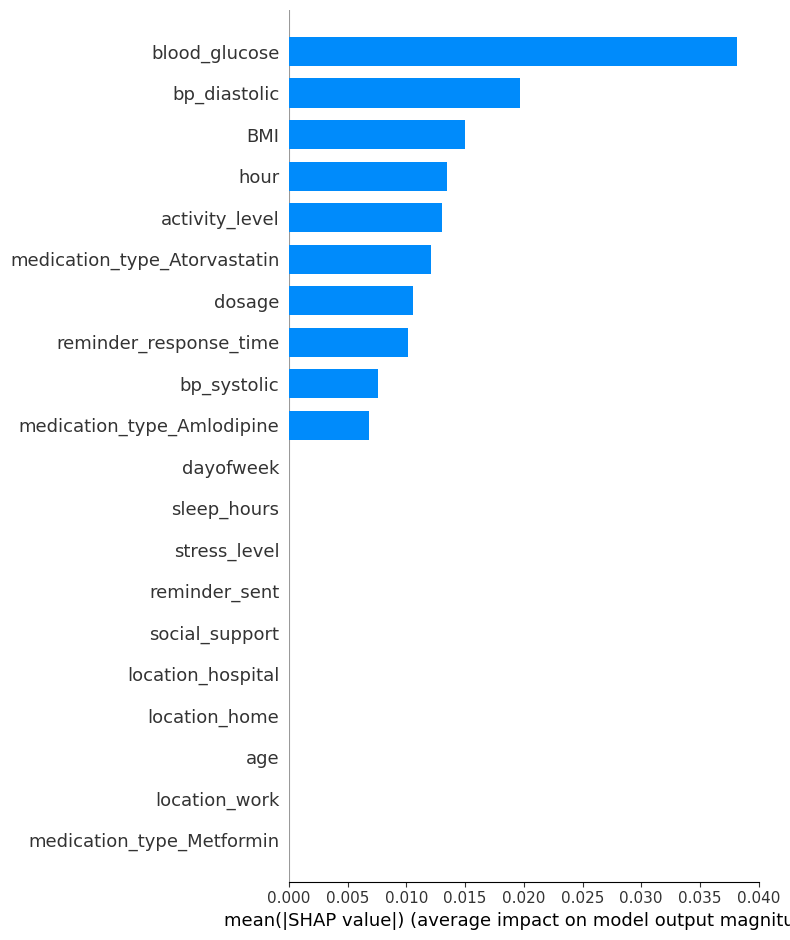

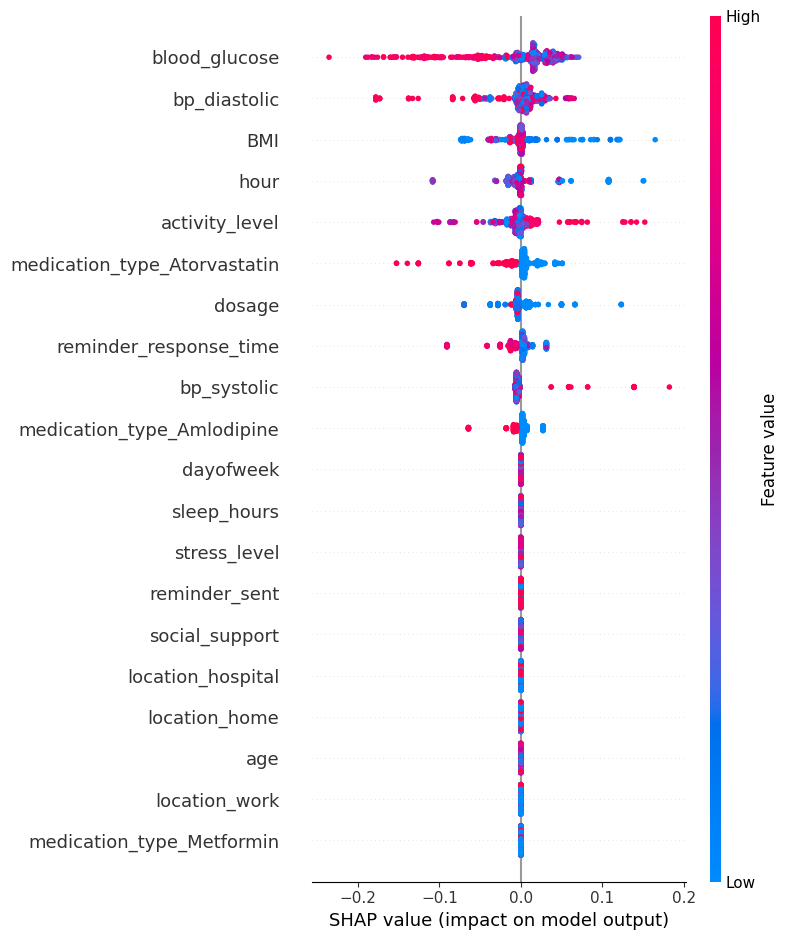

In [ ]:
shap.summary_plot(
    shap_values_positive,
    X_shap_transformed,
    feature_names=feature_names,
    plot_type="bar"
)

shap.summary_plot(
    shap_values_positive,
    X_shap_transformed,
    feature_names=feature_names
)


# LIME — LOCAL EXPLAINABILITY (after SHAP)

In [ ]:
# Pilih sampel individu (ubah idx sesuai kebutuhan)
idx = 100
x_instance = X_test.iloc[idx].values
print(f"Sample index for LIME: {idx}")

Sample index for LIME: 100


In [ ]:
# LIME setup: install/import, wrappers, and explainer initialization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from lime.lime_tabular import LimeTabularExplainer
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "lime"])
    from lime.lime_tabular import LimeTabularExplainer

# Helper: ensure 2D shape
def _ensure_2d(arr):
    arr = np.array(arr)
    if arr.ndim == 1:
        arr = arr.reshape(1, -1)
    return arr

# Robust predict_proba wrapper that accepts numpy arrays (encoded) and returns probabilities
def predict_proba_with_df(arr):
    A = _ensure_2d(arr)
    X_df = pd.DataFrame(A, columns=X_train.columns)
    
    # Decode categorical features back to original string values
    # LIME passes encoded numeric values, but pipeline expects original strings
    for col in _cat_cols:
        if col in X_df.columns:
            # Create reverse mapping: encoded_value -> original_string
            reverse_map = {idx: val for val, idx in _cat_encodings[col].items()}
            X_df[col] = X_df[col].map(reverse_map).fillna(X_df[col])
    
    model = final_pipeline
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X_df)
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_df)
        scores = np.array(scores)
        if scores.ndim == 1:  # binary
            probs1 = 1.0 / (1.0 + np.exp(-scores))
            return np.column_stack([1 - probs1, probs1])
        else:  # multiclass softmax
            exps = np.exp(scores - np.max(scores, axis=1, keepdims=True))
            return exps / exps.sum(axis=1, keepdims=True)
    else:
        # Fallback (not ideal): convert hard predictions into pseudo-probabilities
        preds = model.predict(X_df)
        probs = np.full((len(preds), 2), 0.5, dtype=float)
        for i, p in enumerate(preds):
            if int(p) == 1:
                probs[i] = [0.1, 0.9]
            else:
                probs[i] = [0.9, 0.1]
        return probs

# Detect categorical columns - use the categorical_features defined earlier
if 'categorical_features' in globals() and categorical_features:
    _cat_cols = [c for c in categorical_features if c in X_train.columns]
else:
    _cat_cols = [c for c in X_train.columns if str(X_train[c].dtype) in ("object", "category")]

_categorical_features = [X_train.columns.get_loc(c) for c in _cat_cols]
_categorical_names = {
    X_train.columns.get_loc(c): sorted([str(v) for v in X_train[c].dropna().unique()]) 
    for c in _cat_cols
}

# Map class indices to human-friendly names in the order used by predict_proba
_classes_attr = None
if hasattr(final_pipeline, 'classes_'):
    _classes_attr = list(final_pipeline.classes_)
else:
    try:
        for _name, _step in getattr(final_pipeline, 'named_steps', {}).items():
            if hasattr(_step, 'classes_'):
                _classes_attr = list(_step.classes_)
                break
    except Exception:
        pass
if _classes_attr is None:
    _classes_attr = [0, 1]

_label_names = {0: 'Adherent (0)', 1: 'Non-Adherent (1)'}
_class_names = [_label_names.get(int(c), str(c)) for c in _classes_attr]

# Encode categorical features for LIME training data
X_train_lime = X_train.copy()
_cat_encodings = {}
for col in _cat_cols:
    unique_vals = sorted(X_train[col].dropna().unique())
    _cat_encodings[col] = {val: float(idx) for idx, val in enumerate(unique_vals)}
    # Ensure the mapping is applied correctly
    X_train_lime[col] = X_train[col].fillna('missing').map(_cat_encodings[col])
    # Any values that couldn't be mapped get -1
    X_train_lime[col] = X_train_lime[col].fillna(-1.0)

# Ensure all data is float
for col in X_train_lime.columns:
    if col in _cat_cols:
        X_train_lime[col] = X_train_lime[col].astype(float)
    elif X_train_lime[col].dtype == 'object':
        # Try to convert to float, otherwise use -1
        try:
            X_train_lime[col] = pd.to_numeric(X_train_lime[col], errors='coerce').fillna(-1.0)
        except:
            X_train_lime[col] = -1.0
    else:
        X_train_lime[col] = X_train_lime[col].astype(float)

print("Encoding check:", X_train_lime.dtypes)
print("Sample encoded row:", X_train_lime.iloc[0].values)

# Initialize LIME explainer on the encoded feature space
lime_explainer = LimeTabularExplainer(
    training_data=X_train_lime.values.astype(float),
    feature_names=list(X_train.columns),
    class_names=_class_names,
    categorical_features=_categorical_features if len(_categorical_features) > 0 else None,
    categorical_names=_categorical_names if len(_categorical_names) > 0 else None,
    discretize_continuous=True,
    mode='classification',
    random_state=42
)
print("LIME explainer is ready. Categorical features:", _cat_cols)

Encoding check: age                       float64
gender                    float64
chronic_condition         float64
medication_type           float64
dosage                    float64
comorbidities             float64
BMI                       float64
taken                     float64
missed_reason             float64
device_id                 float64
heart_rate                float64
blood_glucose             float64
activity_level            float64
sleep_hours               float64
stress_level              float64
reminder_sent             float64
reminder_response_time    float64
social_support            float64
location                  float64
hour                      float64
dayofweek                 float64
bp_systolic               float64
bp_diastolic              float64
dtype: object
Sample encoded row: [ 4.500e+01  1.000e+00  2.000e+00  2.000e+00  5.000e+01  0.000e+00
  2.480e+01  1.000e+00 -1.000e+00 -1.000e+00  7.000e+01  1.702e+02
  8.030e+03  5.200e+00  3.000e+00 

Predicted probabilities for the selected sample:
- Adherent (0): 0.4752
- Non-Adherent (1): 0.5248

LIME contributions toward Non-Adherent (1):


,Feature,Weight
0,126.05 < blood_glucose <= 152.70,0.031807
1,reminder_response_time > 78.00,-0.020679
2,device_id > -1.00,0.019565
3,medication_type=Amlodipine,-0.019374
4,hour <= 5.00,0.011545
5,75.00 < bp_diastolic <= 80.00,0.011113
6,10.00 < dosage <= 20.00,-0.007694
7,79.00 < heart_rate <= 90.00,-0.005492
8,age <= 45.00,0.005322
9,26.40 < BMI <= 30.60,-0.004928


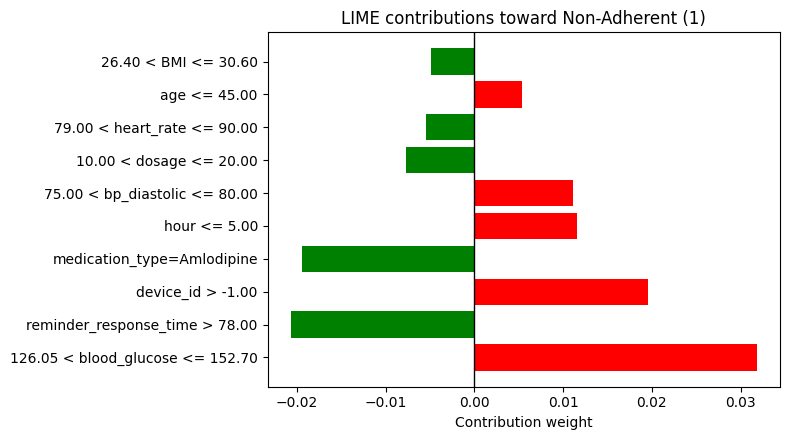


Predicted class: Non-Adherent (1)


In [ ]:
# Run LIME explanation on the selected instance and visualize
# Encode categorical features in the instance
x_instance_lime = X_test.iloc[idx].copy()

# Encode ALL categorical columns (not just _cat_cols)
for col in X_train.columns:
    if X_train[col].dtype in ('object', 'category'):
        # This is a categorical column
        if col in _cat_encodings:
            val = x_instance_lime[col]
            x_instance_lime[col] = _cat_encodings[col].get(val, -1.0)
        else:
            # If not in encodings, encode on the fly
            unique_vals = sorted(X_train[col].dropna().unique())
            mapping = {v: float(i) for i, v in enumerate(unique_vals)}
            _cat_encodings[col] = mapping
            x_instance_lime[col] = mapping.get(x_instance_lime[col], -1.0)
    else:
        # Numeric column
        x_instance_lime[col] = float(x_instance_lime[col])

x_instance_encoded = x_instance_lime.values.astype(float)

# Explain for class 1 if available (Non-Adherent), else fallback to predicted class
exp = lime_explainer.explain_instance(
    data_row=x_instance_encoded,
    predict_fn=predict_proba_with_df,
    num_features=int(min(10, X_train.shape[1])),
    labels=_classes_attr if len(_classes_attr) == 2 else [_classes_attr[0]]
)

# Predicted probabilities for the selected instance
probs = predict_proba_with_df(x_instance)[0]
prob_map = {str(_label_names.get(int(c), str(c))): float(probs[i]) for i, c in enumerate(_classes_attr)}
print("Predicted probabilities for the selected sample:")
for cname in _class_names:
    print(f"- {cname}: {prob_map.get(cname, 'n/a'):.4f}")

# Choose target label for interpretation
if 1 in _classes_attr:
    target_label = 1
else:
    target_label = _classes_attr[int(np.argmax(probs))]

# Contributions toward the chosen label
contribs = exp.as_list(label=target_label)

# Display contributions as a table
import pandas as pd
contrib_df = pd.DataFrame(contribs, columns=["Feature", "Weight"])
print(f"\nLIME contributions toward {_label_names.get(int(target_label), str(target_label))}:")
display(contrib_df)

# Bar chart visualization
import matplotlib.pyplot as plt
features = [f for f, _ in contribs]
weights = np.array([w for _, w in contribs])

# Color logic: positive weight supports target_label
if int(target_label) == 1:
    colors = ['red' if w > 0 else 'green' for w in weights]
else:
    colors = ['green' if w > 0 else 'red' for w in weights]

plt.figure(figsize=(8, max(3, 0.45 * len(weights))))
y = np.arange(len(weights))
plt.barh(y, weights, color=colors)
plt.yticks(y, features)
plt.axvline(0, color='black', linewidth=1)
plt.title(f"LIME contributions toward {_label_names.get(int(target_label), str(target_label))}")
plt.xlabel("Contribution weight")
plt.tight_layout()
plt.show()

pred_class = _classes_attr[int(np.argmax(probs))]
print(f"\nPredicted class: {_label_names.get(int(pred_class), str(pred_class))}")

In [ ]:
print("\n" + "="*80)
print("LIME ANALYSIS FOR 100 PATIENTS - BATCH PROCESSING")
print("="*80)

# ========== 1. BATCH LIME EXPLANATION ==========
import time
from tqdm import tqdm

# Pilih 100 sampel (bisa ubah range sesuai test set size)
sample_indices = np.random.choice(len(X_test), size=min(100, len(X_test)), replace=False)
sample_indices = sorted(sample_indices)

print(f"\n🔍 Processing LIME explanations for {len(sample_indices)} patients...")
print(f"   Patient indices: {sample_indices[:10]}... (showing first 10)")

# Store results
all_explanations = []
start_time = time.time()

for idx_sample in tqdm(sample_indices, desc="LIME Processing"):
    try:
        # Encode instance
        x_instance_lime = X_test.iloc[idx_sample].copy()
        
        for col in X_train.columns:
            if X_train[col].dtype in ('object', 'category'):
                if col in _cat_encodings:
                    val = x_instance_lime[col]
                    x_instance_lime[col] = _cat_encodings[col].get(val, -1.0)
                else:
                    unique_vals = sorted(X_train[col].dropna().unique())
                    mapping = {v: float(i) for i, v in enumerate(unique_vals)}
                    _cat_encodings[col] = mapping
                    x_instance_lime[col] = mapping.get(x_instance_lime[col], -1.0)
            else:
                x_instance_lime[col] = float(x_instance_lime[col])
        
        x_instance_encoded = x_instance_lime.values.astype(float)
        
        # Get LIME explanation
        exp = lime_explainer.explain_instance(
            data_row=x_instance_encoded,
            predict_fn=predict_proba_with_df,
            num_features=10,
            labels=[1]  # Non-Adherent class
        )
        
        # Extract contributions
        contribs = exp.as_list(label=1)
        probs = predict_proba_with_df(x_instance_encoded.reshape(1, -1))[0]
        pred_class = int(np.argmax(probs))
        
        # Store
        for feature, weight in contribs:
            all_explanations.append({
                'Patient_ID': idx_sample,
                'Feature': feature,
                'Weight': weight,
                'Prob_NonAdherent': probs[1],
                'Predicted_Class': pred_class,
                'Abs_Weight': abs(weight)
            })
    
    except Exception as e:
        print(f"   ⚠️ Error processing patient {idx_sample}: {str(e)}")
        continue

elapsed = time.time() - start_time
print(f"✅ Completed in {elapsed:.2f} seconds\n")

# Convert to DataFrame
lime_batch_df = pd.DataFrame(all_explanations)


LIME ANALYSIS FOR 100 PATIENTS - BATCH PROCESSING

🔍 Processing LIME explanations for 100 patients...
   Patient indices: [np.int32(2), np.int32(3), np.int32(7), np.int32(14), np.int32(23), np.int32(31), np.int32(33), np.int32(39), np.int32(42), np.int32(51)]... (showing first 10)


LIME Processing: 100%|██████████| 100/100 [00:23<00:00,  4.30it/s]

✅ Completed in 23.31 seconds



In [ ]:
# ========== 2. AGGREGATE STATISTICS ==========
print("="*80)
print("AGGREGATE LIME STATISTICS (100 Patients)")
print("="*80)

# Average weight per feature across all patients
feature_avg_weight = lime_batch_df.groupby('Feature').agg({
    'Weight': ['mean', 'std', 'min', 'max', 'count'],
    'Abs_Weight': 'mean'
}).round(4)

feature_avg_weight.columns = ['Mean_Weight', 'Std_Weight', 'Min_Weight', 'Max_Weight', 'Frequency', 'Mean_Abs_Weight']
feature_avg_weight = feature_avg_weight.sort_values('Mean_Abs_Weight', ascending=False)

print("\n📊 Feature Contributions Across 100 Patients:")
print(feature_avg_weight.head(15))

AGGREGATE LIME STATISTICS (100 Patients)

📊 Feature Contributions Across 100 Patients:
                                     Mean_Weight  Std_Weight  Min_Weight  \
Feature                                                                    
blood_glucose > 152.70                   -0.0856      0.0041     -0.0948   
device_id > -1.00                        -0.0006      0.0562     -0.1702   
activity_level > 7661.25                  0.0324      0.0038      0.0229   
bp_diastolic > 84.00                     -0.0290      0.0045     -0.0372   
blood_glucose <= 98.47                    0.0289      0.0029      0.0248   
98.47 < blood_glucose <= 126.05           0.0288      0.0027      0.0235   
126.05 < blood_glucose <= 152.70          0.0280      0.0028      0.0206   
medication_type=Atorvastatin             -0.0277      0.0034     -0.0331   
dosage <= 10.00                           0.0252      0.0029      0.0177   
5.00 < hour <= 11.00                     -0.0232      0.0047     -0.0339   
5

C:\Users\User\AppData\Local\Temp\ipykernel_1184\888019626.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(data_for_box, labels=range(1, 11), vert=True)


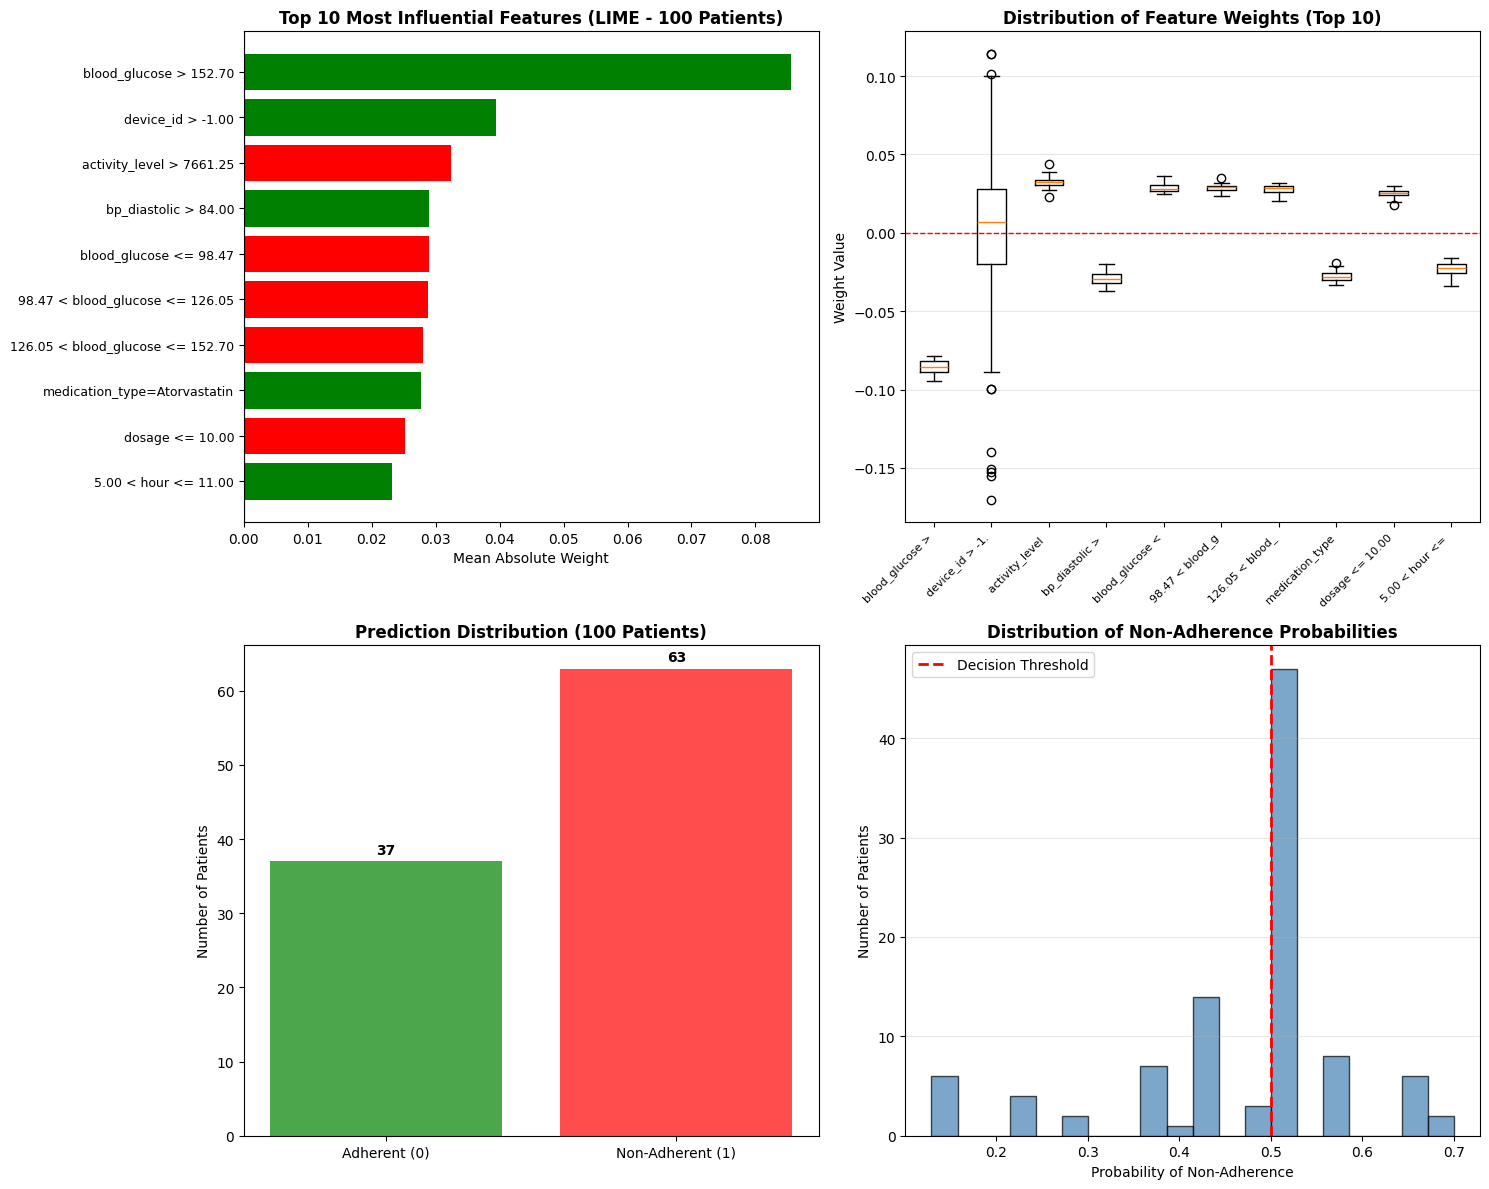


✅ Batch analysis plot saved as 'lime_batch_analysis.png'


In [ ]:
# ========== 3. VISUALIZATIONS ==========

# 3A: Average Weight per Feature
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Mean Absolute Weight (Top 10)
ax1 = axes[0, 0]
top_features = feature_avg_weight.head(10).sort_values('Mean_Abs_Weight')
colors_plot = ['red' if x > 0 else 'green' for x in top_features['Mean_Weight']]
ax1.barh(range(len(top_features)), top_features['Mean_Abs_Weight'], color=colors_plot)
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features.index, fontsize=9)
ax1.set_xlabel('Mean Absolute Weight')
ax1.set_title('Top 10 Most Influential Features (LIME - 100 Patients)', fontweight='bold')
ax1.axvline(0, color='black', linewidth=0.8)

# Plot 2: Weight Distribution by Feature (Box plot)
ax2 = axes[0, 1]
top_10_features = feature_avg_weight.head(10).index
data_for_box = [lime_batch_df[lime_batch_df['Feature'] == f]['Weight'].values for f in top_10_features]
bp = ax2.boxplot(data_for_box, labels=range(1, 11), vert=True)
ax2.set_xticklabels([f.split('<=|>|=')[0].strip()[:15] for f in top_10_features], rotation=45, ha='right', fontsize=8)
ax2.set_ylabel('Weight Value')
ax2.set_title('Distribution of Feature Weights (Top 10)', fontweight='bold')
ax2.axhline(0, color='red', linestyle='--', linewidth=1)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Prediction Distribution
ax3 = axes[1, 0]
pred_dist = lime_batch_df.groupby('Predicted_Class')['Patient_ID'].nunique()
colors_pred = ['green', 'red']
ax3.bar(['Adherent (0)', 'Non-Adherent (1)'], [pred_dist.get(0, 0), pred_dist.get(1, 0)], color=colors_pred, alpha=0.7)
ax3.set_ylabel('Number of Patients')
ax3.set_title('Prediction Distribution (100 Patients)', fontweight='bold')
for i, v in enumerate([pred_dist.get(0, 0), pred_dist.get(1, 0)]):
    ax3.text(i, v + 1, str(v), ha='center', fontweight='bold')

# Plot 4: Probability Distribution
ax4 = axes[1, 1]
patient_probs = lime_batch_df.groupby('Patient_ID')['Prob_NonAdherent'].first()
ax4.hist(patient_probs, bins=20, color='steelblue', alpha=0.7, edgecolor='black')
ax4.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold')
ax4.set_xlabel('Probability of Non-Adherence')
ax4.set_ylabel('Number of Patients')
ax4.set_title('Distribution of Non-Adherence Probabilities', fontweight='bold')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('lime_batch_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Batch analysis plot saved as 'lime_batch_analysis.png'")



In [ ]:
# ========== 4. PATIENT SEGMENTATION BY LIME ==========
print("\n" + "="*80)
print("PATIENT SEGMENTATION ANALYSIS")
print("="*80)

# Create patient summary
patient_summary = lime_batch_df.groupby('Patient_ID').agg({
    'Prob_NonAdherent': 'first',
    'Predicted_Class': 'first',
    'Weight': lambda x: list(x)  # Store all weights
}).reset_index()

patient_summary['Top_Risk_Factor'] = lime_batch_df.groupby('Patient_ID').apply(
    lambda x: x.loc[x['Abs_Weight'].idxmax(), 'Feature']
).values

patient_summary['Top_Risk_Weight'] = lime_batch_df.groupby('Patient_ID').apply(
    lambda x: x.loc[x['Abs_Weight'].idxmax(), 'Weight']
).values

# Categorize patients
def categorize_risk(prob):
    if prob < 0.3:
        return 'Low Risk (Adherent)'
    elif prob < 0.5:
        return 'Moderate Risk (Borderline)'
    elif prob < 0.7:
        return 'High Risk (Borderline)'
    else:
        return 'Very High Risk (Non-Adherent)'

patient_summary['Risk_Category'] = patient_summary['Prob_NonAdherent'].apply(categorize_risk)

print("\n👥 Risk Category Distribution:")
risk_dist = patient_summary['Risk_Category'].value_counts()
for category, count in risk_dist.items():
    pct = (count / len(patient_summary)) * 100
    print(f"   {category:40} : {count:3} patients ({pct:5.1f}%)")



PATIENT SEGMENTATION ANALYSIS

👥 Risk Category Distribution:
   High Risk (Borderline)                   :  63 patients ( 63.0%)
   Moderate Risk (Borderline)               :  25 patients ( 25.0%)
   Low Risk (Adherent)                      :  12 patients ( 12.0%)


C:\Users\User\AppData\Local\Temp\ipykernel_1184\982192527.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_summary['Top_Risk_Factor'] = lime_batch_df.groupby('Patient_ID').apply(
C:\Users\User\AppData\Local\Temp\ipykernel_1184\982192527.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_summary['Top_Risk_Weight'] = lime_batch_df.groupby('Patient_ID').apply(


In [ ]:
# ========== 5. TOP RISK FACTORS BY CATEGORY ==========
print("\n" + "="*80)
print("TOP RISK FACTORS BY RISK CATEGORY")
print("="*80)

for category in patient_summary['Risk_Category'].unique():
    patients_in_cat = patient_summary[patient_summary['Risk_Category'] == category]['Patient_ID'].values
    
    if len(patients_in_cat) > 0:
        lime_subset = lime_batch_df[lime_batch_df['Patient_ID'].isin(patients_in_cat)]
        top_factors = lime_subset.groupby('Feature')['Abs_Weight'].mean().sort_values(ascending=False).head(5)
        
        print(f"\n🎯 {category} (n={len(patients_in_cat)}):")
        for i, (feature, weight) in enumerate(top_factors.items(), 1):
            print(f"   {i}. {feature[:50]:50} (avg abs weight: {weight:.4f})")




TOP RISK FACTORS BY RISK CATEGORY

🎯 Moderate Risk (Borderline) (n=25):
   1. blood_glucose > 152.70                             (avg abs weight: 0.0866)
   2. activity_level > 7661.25                           (avg abs weight: 0.0320)
   3. 126.05 < blood_glucose <= 152.70                   (avg abs weight: 0.0315)
   4. blood_glucose <= 98.47                             (avg abs weight: 0.0291)
   5. bp_diastolic > 84.00                               (avg abs weight: 0.0285)

🎯 Low Risk (Adherent) (n=12):
   1. device_id > -1.00                                  (avg abs weight: 0.1085)
   2. blood_glucose > 152.70                             (avg abs weight: 0.0857)
   3. missed_reason > -1.00                              (avg abs weight: 0.0833)
   4. bp_diastolic > 84.00                               (avg abs weight: 0.0309)
   5. medication_type=Atorvastatin                       (avg abs weight: 0.0304)

🎯 High Risk (Borderline) (n=63):
   1. blood_glucose > 152.70              

In [ ]:
# ========== 6. FEATURE CONSISTENCY ANALYSIS ==========
print("\n" + "="*80)
print("FEATURE CONSISTENCY & VARIABILITY")
print("="*80)

consistency_df = feature_avg_weight[['Mean_Weight', 'Std_Weight', 'Mean_Abs_Weight', 'Frequency']].copy()
consistency_df['Consistency_Score'] = 1 - (consistency_df['Std_Weight'] / (consistency_df['Mean_Abs_Weight'] + 0.001))
consistency_df = consistency_df.sort_values('Consistency_Score', ascending=False)

print("\n📈 Feature Consistency (1.0 = Consistent, <0 = Highly Variable):")
print(consistency_df[['Mean_Abs_Weight', 'Std_Weight', 'Consistency_Score']].head(10).round(4))



FEATURE CONSISTENCY & VARIABILITY

📈 Feature Consistency (1.0 = Consistent, <0 = Highly Variable):
                                  Mean_Abs_Weight  Std_Weight  \
Feature                                                         
blood_glucose > 152.70                     0.0856      0.0041   
5.28 < sleep_hours <= 6.50                 0.0064      0.0005   
location=work                              0.0047      0.0005   
98.47 < blood_glucose <= 126.05            0.0288      0.0027   
126.05 < blood_glucose <= 152.70           0.0280      0.0028   
blood_glucose <= 98.47                     0.0289      0.0029   
dosage <= 10.00                            0.0252      0.0029   
activity_level > 7661.25                   0.0324      0.0038   
medication_type=Metformin                  0.0187      0.0023   
medication_type=Atorvastatin               0.0277      0.0034   

                                  Consistency_Score  
Feature                                              
blood_gluco

In [ ]:
# ========== 7. SUMMARY TABLE ==========
print("\n" + "="*80)
print("SUMMARY: KEY FINDINGS FROM 100 PATIENTS")
print("="*80)

summary_text = f"""
✅ LIME BATCH ANALYSIS SUMMARY:

1. SAMPLE SIZE: {len(sample_indices)} patients analyzed
   
2. PREDICTION DISTRIBUTION:
   • Adherent (0):      {pred_dist.get(0, 0):3} patients ({pred_dist.get(0, 0)/len(sample_indices)*100:5.1f}%)
   • Non-Adherent (1):  {pred_dist.get(1, 0):3} patients ({pred_dist.get(1, 0)/len(sample_indices)*100:5.1f}%)

3. TOP 5 INFLUENTIAL FEATURES:
"""

for i, (feature, row) in enumerate(feature_avg_weight.head(5).iterrows(), 1):
    direction = "↑ INCREASES" if row['Mean_Weight'] > 0 else "↓ DECREASES"
    summary_text += f"   {i}. {feature:50} {direction:15} non-adherence (weight: {row['Mean_Weight']:+.4f})\n"

summary_text += f"""
4. FEATURE VARIABILITY:
   • Most Consistent: {consistency_df.index[0]} (score: {consistency_df.iloc[0]['Consistency_Score']:.3f})
   • Most Variable:   {consistency_df.index[-1]} (score: {consistency_df.iloc[-1]['Consistency_Score']:.3f})

5. PROBABILITY STATISTICS:
   • Mean Non-Adherence Prob:  {patient_summary['Prob_NonAdherent'].mean():.4f}
   • Std Non-Adherence Prob:   {patient_summary['Prob_NonAdherent'].std():.4f}
   • Range: [{patient_summary['Prob_NonAdherent'].min():.4f}, {patient_summary['Prob_NonAdherent'].max():.4f}]

6. KEY INSIGHT:
   Features with HIGH mean weight and LOW std dev are most RELIABLE predictors
   across the patient population.
"""

print(summary_text)


SUMMARY: KEY FINDINGS FROM 100 PATIENTS

✅ LIME BATCH ANALYSIS SUMMARY:

1. SAMPLE SIZE: 100 patients analyzed

2. PREDICTION DISTRIBUTION:
   • Adherent (0):       37 patients ( 37.0%)
   • Non-Adherent (1):   63 patients ( 63.0%)

3. TOP 5 INFLUENTIAL FEATURES:
   1. blood_glucose > 152.70                             ↓ DECREASES     non-adherence (weight: -0.0856)
   2. device_id > -1.00                                  ↓ DECREASES     non-adherence (weight: -0.0006)
   3. activity_level > 7661.25                           ↑ INCREASES     non-adherence (weight: +0.0324)
   4. bp_diastolic > 84.00                               ↓ DECREASES     non-adherence (weight: -0.0290)
   5. blood_glucose <= 98.47                             ↑ INCREASES     non-adherence (weight: +0.0289)

4. FEATURE VARIABILITY:
   • Most Consistent: blood_glucose > 152.70 (score: 0.953)
   • Most Variable:   stress_level > 4.00 (score: nan)

5. PROBABILITY STATISTICS:
   • Mean Non-Adherence Prob:  0.4717
   •

In [ ]:
# ========== 8. EXPORT RESULTS ==========
import os

print("\n" + "="*80)
print("EXPORTING DETAILED RESULTS")
print("="*80)

# Create output directory if it doesn't exist
output_dir = 'lime_analysis 100 patient'
os.makedirs(output_dir, exist_ok=True)

# Save detailed results
lime_batch_df.to_csv(os.path.join(output_dir, 'lime_100_patients_detailed.csv'), index=False)
patient_summary.to_csv(os.path.join(output_dir, 'lime_100_patients_summary.csv'), index=False)
feature_avg_weight.to_csv(os.path.join(output_dir, 'lime_feature_statistics.csv'))

# Update the plot save path in cell above
# Change this line in the visualization cell:
# plt.savefig('lime_batch_analysis.png', dpi=300, bbox_inches='tight')
# To:
# plt.savefig(os.path.join('lime_analysis', 'lime_batch_analysis.png'), dpi=300, bbox_inches='tight')

print(f"\n✅ Files saved to '{output_dir}/' folder:")
print(f"   • {output_dir}/lime_100_patients_detailed.csv")
print(f"   • {output_dir}/lime_100_patients_summary.csv")
print(f"   • {output_dir}/lime_feature_statistics.csv")
print(f"   • {output_dir}/lime_batch_analysis.png")

print(f"\n📂 Full path: {os.path.abspath(output_dir)}")


EXPORTING DETAILED RESULTS

✅ Files saved to 'lime_analysis 100 patient/' folder:
   • lime_analysis 100 patient/lime_100_patients_detailed.csv
   • lime_analysis 100 patient/lime_100_patients_summary.csv
   • lime_analysis 100 patient/lime_feature_statistics.csv
   • lime_analysis 100 patient/lime_batch_analysis.png

📂 Full path: d:\TESIS\Simulasi\Improving-Machine-Learning-Model-Performance-for-Patient-Non-Adherence-Prediction\lime_analysis 100 patient
